In [1]:
import torch
from torchvision import datasets, transforms
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# Skapa en transform för att redan vid load...
transform = transforms.Compose([
    transforms.RandomAffine(degrees=(-2,2)),
    transforms.ToTensor(),    # ... 1) konvertera data till [0.0-1.0]
    transforms.Normalize((0.5,),(0.5,)) # ... och 2) normalisera gråskalan
])

# MNIST är så vanligt att det finns som funktion i datasets
train_set = datasets.MNIST(root='./data', train=True,  download=True, transform=transform)
test_set  = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Skapa en DataLoader för träningsdata och en för testdata
from torch.utils.data import DataLoader
train_loader = DataLoader(train_set, batch_size=64, num_workers=4, pin_memory=True, shuffle=True)
test_loader  = DataLoader(test_set,  batch_size=64, shuffle=False)


100.0%


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100.0%


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



100.0%


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



100.0%

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [2]:
import torch.nn as nn
import torch.optim as optim

class CNN(nn.Module):
    def __init__(self):
      super(CNN,self).__init__()
      self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, stride=1)
      self.conv2 = nn.Conv2d(32, 64, 3, 1)
      self.bn1 = nn.BatchNorm2d(64)
      self.dropout1 = nn.Dropout2d(0.25)
      self.dropout2 = nn.Dropout2d(0.5)
      self.fc1 = nn.Linear(1600, 128)
      self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
      x = self.conv1(x)
      x = nn.functional.relu(x)
      x = nn.functional.max_pool2d(x, 2)
      x = self.dropout1(x)
      x = self.conv2(x)
      x = self.bn1(x)
      x = nn.functional.relu(x)
      x = nn.functional.max_pool2d(x, 2)
      x = self.dropout1(x)
      x = torch.flatten(x, 1)
      x = self.fc1(x)
      x = nn.functional.relu(x)
      x = self.dropout2(x)
      x = self.fc2(x)
      output = nn.functional.log_softmax(x, dim=1)
      return output

/Users/linussoderberg/Skolprojekt/mnist/venv/lib/python3.11/site-packages/torch/nn/functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch 1, Batch 100, Loss: 1.0570
Epoch 1, Batch 200, Loss: 0.3682
Epoch 1, Batch 300, Loss: 0.2764
Epoch 1, Batch 400, Loss: 0.2265
Epoch 1, Batch 500, Loss: 0.2087
Epoch 1, Batch 600, Loss: 0.1712
Epoch 1, Batch 700, Loss: 0.1614
Epoch 1, Batch 800, Loss: 0.1629
Epoch 1, Batch 900, Loss: 0.1530
Epoch 2, Batch 100, Loss: 0.1353
Epoch 2, Batch 200, Loss: 0.1290
Epoch 2, Batch 300, Loss: 0.1166
Epoch 2, Batch 400, Loss: 0.1201
Epoch 2, Batch 500, Loss: 0.1326
Epoch 2, Batch 600, Loss: 0.1226
Epoch 2, Batch 700, Loss: 0.1088
Epoch 2, Batch 800, Loss: 0.1079
Epoch 2, Batch 900, Loss: 0.1177
Epoch 3, Batch 100, Loss: 0.1087
Epoch 3, Batch 200, Loss: 0.0960
Epoch 3, Batch 300, Loss: 0.0895
Epoch 3, Batch 400, Loss: 0.0899
Epoch 3, Batch 500, Loss: 0.0937
Epoch 3, Batch 600, Loss: 0.0946
Epoch 3, Batch 700, Loss: 0.0944
Epoch 3, Batch 800, Loss: 0.0990
Epoch 3, Batch 900, Loss: 0.1050
Epoch 4, Batch 100, Loss: 0.0909
Epoch 4, Batch 200, Loss: 0.0942
Epoch 4, Batch 300, Loss: 0.0826
Epoch 4, B

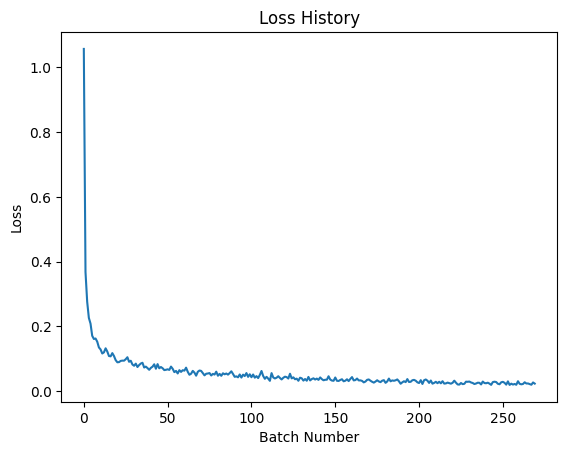

In [3]:
import matplotlib.pyplot as plt
loss_history = []

model = CNN()

if torch.cuda.is_available():
    model.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

for epoch in range(30):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        if torch.cuda.is_available():
            inputs, labels = inputs.cuda(), labels.cuda()
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 100 == 99:
            current_loss = running_loss / 100
            loss_history.append(current_loss)   
            print(f'Epoch {epoch + 1}, Batch {i + 1}, Loss: {current_loss:.4f}')
            running_loss = 0.0

plt.plot(loss_history)
plt.title('Loss History')
plt.xlabel('Batch Number')
plt.ylabel('Loss')
plt.show()

In [4]:
incorrect_images = []
incorrect_labels = []
predicted_labels = []
total = 0
correct = 0

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        mask = (predicted != labels)
        incorrect_images.extend(images[mask])
        incorrect_labels.extend(labels[mask])
        predicted_labels.extend(predicted[mask])

print(f'Accuracy of the network on the test images: {100 * correct / total:.2f}%')

/Users/linussoderberg/Skolprojekt/mnist/venv/lib/python3.11/site-packages/torch/nn/functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
/Users/linussoderberg/Skolprojekt/mnist/venv/lib/python3.11/site-packages/torch/nn/functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.w

Accuracy of the network on the test images: 98.90%


In [6]:
import datetime
import os
current_time = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
model_path = os.path.join('versions', f'{current_time}.pth')
torch.save(model.state_dict(), model_path)

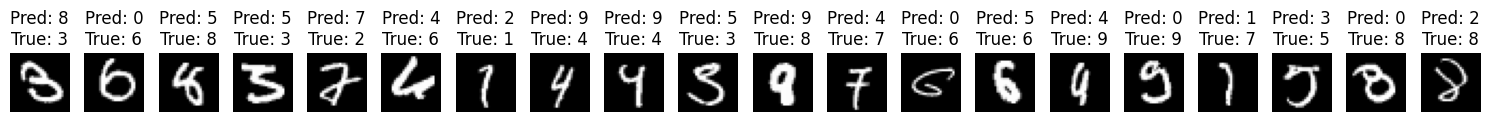

In [5]:
import matplotlib.pyplot as plt

num_images_to_show = 20

fig, axes = plt.subplots(nrows=1, ncols=num_images_to_show, figsize=(15, 3))

for idx, ax in enumerate(axes):
    if idx < len(incorrect_images):
        image = incorrect_images[idx].cpu().numpy().squeeze()  
        true_label = incorrect_labels[idx].cpu().item()
        pred_label = predicted_labels[idx].cpu().item()

        ax.imshow(image, cmap='gray')  
        ax.set_title(f'Pred: {pred_label}\nTrue: {true_label}')
        ax.axis('off')
    else:
        ax.axis('off')  

plt.tight_layout()
plt.show()